# Hyperparameter Tuning with ktrain and ResNet50 
In order to improve upon the performance of the models I have constructed previously, I used ktrain, a wrapper for Keras, to tune the learning rate. Rather than make use of Scikit-Learn's functionality due to memory constraints, I operated on the assumption that the images had been randomly selected to be in both the train and test sets. This permitted use of the entire data set.

Since Google Cloud was utilized, I needed to install ktrain.

In [2]:
# !pip install ktrain

### Importing Library and Data 
The pixels were rescaled and the images resized due to how Keras' pretrained networks are set up.

In [3]:
import ktrain
from ktrain import vision as vis

In [4]:
DATADIR = 'DATASET_2/DATASET'
(train_data, val_data, preproc) = vis.images_from_folder(datadir=DATADIR,
                                              # use a default data augmentation with horizontal_flip=True
                                              data_aug=vis.get_data_aug(rescale = 1./255), 
                                              train_test_names=['TRAIN', 'TEST'],
                                               target_size=(224,224), color_mode='rgb'
                                                        )

Found 22564 images belonging to 2 classes.
Found 22564 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


### Example Images 
Notice that the organic materials are anything from raw food stuffs to cooked food, and the non-organic is self-explanatory.

sample organic images:


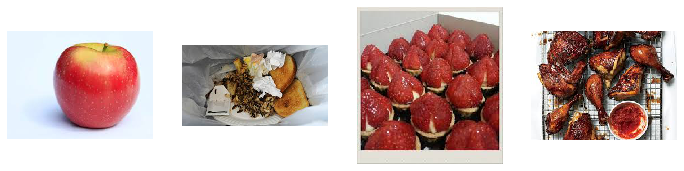

In [11]:
print('sample organic images:')
vis.show_random_images(DATADIR + '/TRAIN/O/') 

sample inorganic images:


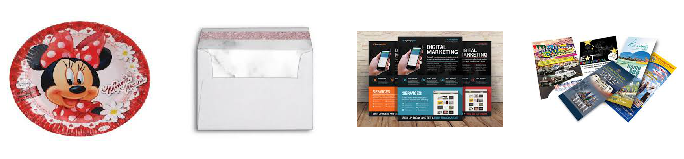

In [12]:
print('sample inorganic images:')
vis.show_random_images(DATADIR + '/TRAIN/R/')

### Transfer Learning with ResNet50 
Since the convolutional neural networks available in Keras have been pre-trained on the ImageNet library that contains over 14 million images, they can outperform what I can establish with such a small data set. Thus, I have opted for transfer learning, freezing the first 15 layers to preserve those weights (the number of layers frozen could be considered another hyperparameter). The layers are defined below where a single dense layer is used and preceded by a dropout regularization layer.

In [5]:
model = vis.image_classifier('pretrained_resnet50', train_data, val_data)
learner = ktrain.get_learner(model=model, train_data=train_data, val_data=val_data, 
                             workers=8, use_multiprocessing=False, batch_size=64)

The normalization scheme has been changed for use with a pretrained_resnet50 model. If you decide to use a different model, please reload your dataset with a ktrain.vision.data.images_from* function.

Is Multi-Label? False
Is Regression? False
94773248/94765736 [==============================] - 1s 0us/step
pretrained_resnet50 model created.


In [6]:
learner.freeze(freeze_range=15)

In [7]:
learner.print_layers()

0 (trainable=False) : <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f968bb8f890>
1 (trainable=False) : <tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7f9716a75090>
2 (trainable=False) : <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f968c87bb50>
3 (trainable=False) : <tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x7f9692da1cd0>
4 (trainable=False) : <tensorflow.python.keras.layers.core.Activation object at 0x7f968bb8f590>
5 (trainable=False) : <tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7f96882fa490>
6 (trainable=False) : <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f96882fa290>
7 (trainable=False) : <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9688245410>
8 (trainable=False) : <tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x7f9688247a50>
9 (trainable=False) : <tensorflow.python.keras.layers.co

### Learning Rate 
Here, I am searching for a good initial learning rate. The loss function obtains a minimum close to 1e-4.

In [10]:
learner.lr_find(max_epochs = 5)

simulating training for different learning rates... this may take a few moments...
Train for 352 steps
Epoch 1/5
352/352 [==============================] - 4198s 12s/step - loss: 0.3695 - accuracy: 0.9117
Epoch 2/5
352/352 [==============================] - 4235s 12s/step - loss: 0.3118 - accuracy: 0.9229
Epoch 3/5
138/352 [==========>...................] - ETA: 42:59 - loss: 0.4959 - accuracy: 0.9061

done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


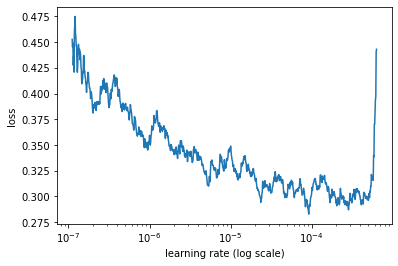

In [11]:
learner.lr_plot()

### Training 
The training process was lengthy, taking many epochs. When connection was lost to Google Cloud, I paused the notebook and started a new segment to keep track of everything. Should the loss seem to be stuck on a plateau, ktrain lowers the learning rate so the step size is not so large. Similarly, early stopping is implemented, and the weights from the best epoch are stored. Towards the end, the training accuracy hovered around 99%, but the best test accuracy obtained was 93% - a six percentage point improvement to the prior models.

In [ ]:
learner.autofit(1e-4)

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.0001...
Train for 353 steps, validate for 79 steps
Epoch 1/1024
353/353 [==============================] - 4355s 12s/step - loss: 0.1391 - accuracy: 0.9521 - val_loss: 0.4376 - val_accuracy: 0.8953
Epoch 2/1024
353/353 [==============================] - 4202s 12s/step - loss: 0.1179 - accuracy: 0.9572 - val_loss: 0.4692 - val_accuracy: 0.8870
Epoch 3/1024
 56/353 [===>..........................] - ETA: 57:24 - loss: 0.0953 - accuracy: 0.9632

In [ ]:
learner.autofit(1e-4)

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.0001...
Train for 353 steps, validate for 79 steps
Epoch 1/1024
353/353 [==============================] - 4365s 12s/step - loss: 0.0773 - accuracy: 0.9731 - val_loss: 0.4284 - val_accuracy: 0.9089
Epoch 2/1024
209/353 [================>.............] - ETA: 28:45 - loss: 0.0794 - accuracy: 0.9717

In [ ]:
learner.autofit(1e-4)

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.0001...
Train for 353 steps, validate for 79 steps
Epoch 1/1024
353/353 [==============================] - 4357s 12s/step - loss: 0.0756 - accuracy: 0.9731 - val_loss: 0.4505 - val_accuracy: 0.9268
Epoch 2/1024
353/353 [==============================] - 4353s 12s/step - loss: 0.0660 - accuracy: 0.9762 - val_loss: 0.6049 - val_accuracy: 0.9121
Epoch 3/1024
352/353 [============================>.] - ETA: 12s - loss: 0.0610 - accuracy: 0.9774
Epoch 00003: Reducing Max LR on Plateau: new max lr will be 5e-05 (if not early_stopping).
353/353 [==============================] - 4349s 12s/step - loss: 0.0611 - accuracy: 0.9774 - val_loss: 0.5352 - val_accuracy: 0.9097
Epoch 4/1024
353/353 [==============================] - 4352s 12s/step - loss: 0.0435 - accuracy: 0.9837 - val_loss: 0.4155 - val_accuracy: 0.9248
Epoch 5

In [ ]:
learner.autofit(5e-5)

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 5e-05...
Train for 353 steps, validate for 79 steps
Epoch 1/1024
353/353 [==============================] - 4374s 12s/step - loss: 0.0379 - accuracy: 0.9859 - val_loss: 0.6534 - val_accuracy: 0.9156
Epoch 2/1024
353/353 [==============================] - 4366s 12s/step - loss: 0.0404 - accuracy: 0.9849 - val_loss: 0.3955 - val_accuracy: 0.9371
Epoch 3/1024
 75/353 [=====>........................] - ETA: 56:06 - loss: 0.0293 - accuracy: 0.9885

In [ ]:
learner.autofit(5e-5)

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 5e-05...
Train for 353 steps, validate for 79 steps
Epoch 1/1024
353/353 [==============================] - 4413s 13s/step - loss: 0.0311 - accuracy: 0.9893 - val_loss: 0.4995 - val_accuracy: 0.9244
Epoch 2/1024
250/353 [====================>.........] - ETA: 20:51 - loss: 0.0295 - accuracy: 0.9891

In [ ]:
learner.autofit(5e-5)

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 5e-05...
Train for 353 steps, validate for 79 steps
Epoch 1/1024
353/353 [==============================] - 4351s 12s/step - loss: 0.0229 - accuracy: 0.9929 - val_loss: 0.6122 - val_accuracy: 0.9204
Epoch 2/1024
353/353 [==============================] - 4323s 12s/step - loss: 0.0230 - accuracy: 0.9915 - val_loss: 0.5581 - val_accuracy: 0.9188
Epoch 3/1024
353/353 [==============================] - 4308s 12s/step - loss: 0.0248 - accuracy: 0.9920 - val_loss: 0.6623 - val_accuracy: 0.9133
Epoch 4/1024
352/353 [============================>.] - ETA: 11s - loss: 0.0279 - accuracy: 0.9906
Epoch 00004: Reducing Max LR on Plateau: new max lr will be 2.5e-05 (if not early_stopping).
353/353 [==============================] - 4224s 12s/step - loss: 0.0281 - accuracy: 0.9906 - val_loss: 0.6874 - val_accuracy: 0.9109
Epoch 

In [ ]:
learner.autofit(2.5e-5)

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 2.5e-05...
Train for 353 steps, validate for 79 steps
Epoch 1/1024
353/353 [==============================] - 4311s 12s/step - loss: 0.0186 - accuracy: 0.9934 - val_loss: 0.5533 - val_accuracy: 0.9288
Epoch 2/1024
353/353 [==============================] - 4267s 12s/step - loss: 0.0139 - accuracy: 0.9956 - val_loss: 0.5486 - val_accuracy: 0.9280
Epoch 3/1024
 62/353 [====>.........................] - ETA: 56:45 - loss: 0.0160 - accuracy: 0.9950

In [17]:
learner.autofit(2.5e-5)

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 2.5e-05...
Train for 353 steps, validate for 79 steps
Epoch 1/1024
353/353 [==============================] - 4305s 12s/step - loss: 0.0155 - accuracy: 0.9951 - val_loss: 0.7078 - val_accuracy: 0.9248
Epoch 2/1024
353/353 [==============================] - 4317s 12s/step - loss: 0.0141 - accuracy: 0.9952 - val_loss: 0.4683 - val_accuracy: 0.9327
Epoch 3/1024
353/353 [==============================] - 4258s 12s/step - loss: 0.0138 - accuracy: 0.9955 - val_loss: 0.6094 - val_accuracy: 0.9232
Epoch 4/1024
352/353 [============================>.] - ETA: 11s - loss: 0.0092 - accuracy: 0.9969
Epoch 00004: Reducing Max LR on Plateau: new max lr will be 1.25e-05 (if not early_stopping).
353/353 [==============================] - 4296s 12s/step - loss: 0.0092 - accuracy: 0.9969 - val_loss: 0.6112 - val_accuracy: 0.9308
Epo

In [21]:
loss, acc = learner.model.evaluate_generator(learner.val_data, 
                                             steps=len(learner.val_data))

In [22]:
print('final loss:%s, final accuracy:%s' % (loss, acc))

final loss:0.6028009102319082, final accuracy:0.93434143
